In [1]:
import pandas as pd

df = pd.read_excel("/content/Online Retail.xlsx")
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
print("Missing values before handling:")
print(df.isnull().sum())

print("\nData types before handling:")
print(df.dtypes)

# handling the missing CustomerID by dropping rows
df.dropna(subset=['CustomerID'], inplace=True)

# just Converting InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')

df.dropna(subset=['Quantity', 'UnitPrice'], inplace=True)


print("\nMissing values after handling:")
print(df.isnull().sum())

print("\nData types after handling:")
print(df.dtypes)


Missing values before handling:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Data types before handling:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Missing values after handling:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Data types after handling:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [3]:
import datetime as dt

# 'TotalAmount'
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# the most recent transaction date
most_recent_date = df['InvoiceDate'].max()

# Recency, Frequency, and Monetary
rfm_df = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (most_recent_date - date.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalAmount', 'sum')
)

display(rfm_df.head())

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


In [4]:
# 1. quartiles
quantiles = rfm_df.quantile([0.25, 0.5, 0.75])

# 2. scoring functions (using quartiles)
def r_score(recency, quantiles):
    if recency <= quantiles['Recency'][0.25]:
        return 4
    elif recency <= quantiles['Recency'][0.5]:
        return 3
    elif recency <= quantiles['Recency'][0.75]:
        return 2
    else:
        return 1

def f_score(frequency, quantiles):
    if frequency <= quantiles['Frequency'][0.25]:
        return 1
    elif frequency <= quantiles['Frequency'][0.5]:
        return 2
    elif frequency <= quantiles['Frequency'][0.75]:
        return 3
    else:
        return 4

def m_score(monetary, quantiles):
    if monetary <= quantiles['Monetary'][0.25]:
        return 1
    elif monetary <= quantiles['Monetary'][0.5]:
        return 2
    elif monetary <= quantiles['Monetary'][0.75]:
        return 3
    else:
        return 4

# 3. scoring functions
rfm_df['R_Score'] = rfm_df['Recency'].apply(lambda x: r_score(x, quantiles))
rfm_df['F_Score'] = rfm_df['Frequency'].apply(lambda x: f_score(x, quantiles))
rfm_df['M_Score'] = rfm_df['Monetary'].apply(lambda x: m_score(x, quantiles))

# 4. first few rows
display(rfm_df.head())

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
CustomerID,,,,,,
12346.0,325,2,0.00,1,2,1
12347.0,1,7,4310.00,4,4,4
12348.0,74,4,1797.24,2,3,4
12349.0,18,1,1757.55,3,1,4
12350.0,309,1,334.40,1,1,2


In [5]:
# 'RFM_Segment' by concatenating the scores
rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

# 'RFM_Score' by summing the scores
rfm_df['RFM_Score'] = rfm_df['R_Score'] + rfm_df['F_Score'] + rfm_df['M_Score']

# first few rows of the updated dataframe
display(rfm_df.head())

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,325,2,0.00,1,2,1,121,4
12347.0,1,7,4310.00,4,4,4,444,12
12348.0,74,4,1797.24,2,3,4,234,9
12349.0,18,1,1757.55,3,1,4,314,8
12350.0,309,1,334.40,1,1,2,112,4


In [6]:
# Group by 'RFM_Segment' and the mean of RFM values
segment_characteristics = rfm_df.groupby('RFM_Segment')[['Recency', 'Frequency', 'Monetary']].mean()

# segments sorted by mean Monetary value in descending order
segment_characteristics = segment_characteristics.sort_values(by='Monetary', ascending=False)

# the segment characteristics
display(segment_characteristics)

,Recency,Frequency,Monetary
RFM_Segment,,,
444,5.847390,18.819277,8780.148876
344,28.274038,11.572115,4978.654808
134,235.750000,4.500000,4162.663333
414,2.000000,1.000000,3861.000000
144,195.142857,11.357143,3688.114286
...,...,...,...
411,8.963636,1.000000,165.228909
211,84.285714,1.000000,161.282571
141,228.000000,6.500000,133.310000


In [11]:
# "this took quite some time.."  Business Interpretation (strategy layer)
# segment names and map them to RFM ranges
segment_definitions = {
    "Champions": {"R": (4, 4), "F": (4, 4), "M": (4, 4)},
    "Loyal Customers": {"R": (3, 4), "F": (3, 4), "M": (3, 4)},
    "Potential Loyalists": {"R": (3, 4), "F": (2, 3), "M": (2, 3)},
    "New Customers": {"R": (4, 4), "F": (1, 1), "M": (1, 1)},
    "At Risk": {"R": (1, 2), "F": (3, 4), "M": (3, 4)},
    "Hibernating": {"R": (1, 2), "F": (1, 2), "M": (1, 2)}
}

# marketing strategies for each defined segment
marketing_strategies = {
    "Champions": [
        "Reward them with exclusive offers or early access to new products.",
        "Recognize their loyalty publicly or through a VIP program.",
        "Involve them in beta testing or feedback sessions.",
        "Encourage them to refer friends and family."
    ],
    "Loyal Customers": [
        "Offer loyalty discounts or special promotions.",
        "Recommend higher-value products or complementary items.",
        "Provide personalized shopping experiences.",
        "Create a tiered loyalty program to encourage reaching 'Champion' status."
    ],
    "Potential Loyalists": [
        "Offer incentives for repeat purchases.",
        "Send personalized recommendations based on their past behavior.",
        "Provide excellent customer service to build trust.",
        "Engage them through targeted content or social media."
    ],
    "New Customers": [
        "Send welcome emails with guides or tips.",
        "Offer a small discount on their second purchase to encourage repeat business.",
        "Provide excellent onboarding experience.",
        "Gather feedback on their first purchase experience."
    ],
    "At Risk": [
        "Send personalized re-engagement emails or offers.",
        "Highlight new products or features they might be interested in.",
        "Offer discounts or incentives to encourage them to return.",
        "Conduct surveys to understand why they've reduced activity."
    ],
    "Hibernating": [
        "Consider if re-engagement efforts are cost-effective for this group.",
        "Send low-cost targeted campaigns highlighting major changes or offers.",
        "Use win-back campaigns with significant discounts (if profitable).",
        "Analyze if there are specific reasons for their inactivity (e.g., seasonality, product relevance)."
    ]
}

# strategies for each segment
for segment, strategies in marketing_strategies.items():
    print(f"--- {segment} ---")
    for strategy in strategies:
        print(f"- {strategy}")
    print("\n")

--- Champions ---
- Reward them with exclusive offers or early access to new products.
- Recognize their loyalty publicly or through a VIP program.
- Involve them in beta testing or feedback sessions.
- Encourage them to refer friends and family.


--- Loyal Customers ---
- Offer loyalty discounts or special promotions.
- Recommend higher-value products or complementary items.
- Provide personalized shopping experiences.
- Create a tiered loyalty program to encourage reaching 'Champion' status.


--- Potential Loyalists ---
- Offer incentives for repeat purchases.
- Send personalized recommendations based on their past behavior.
- Provide excellent customer service to build trust.
- Engage them through targeted content or social media.


--- New Customers ---
- Send welcome emails with guides or tips.
- Offer a small discount on their second purchase to encourage repeat business.
- Provide excellent onboarding experience.
- Gather feedback on their first purchase experience.


--- At R

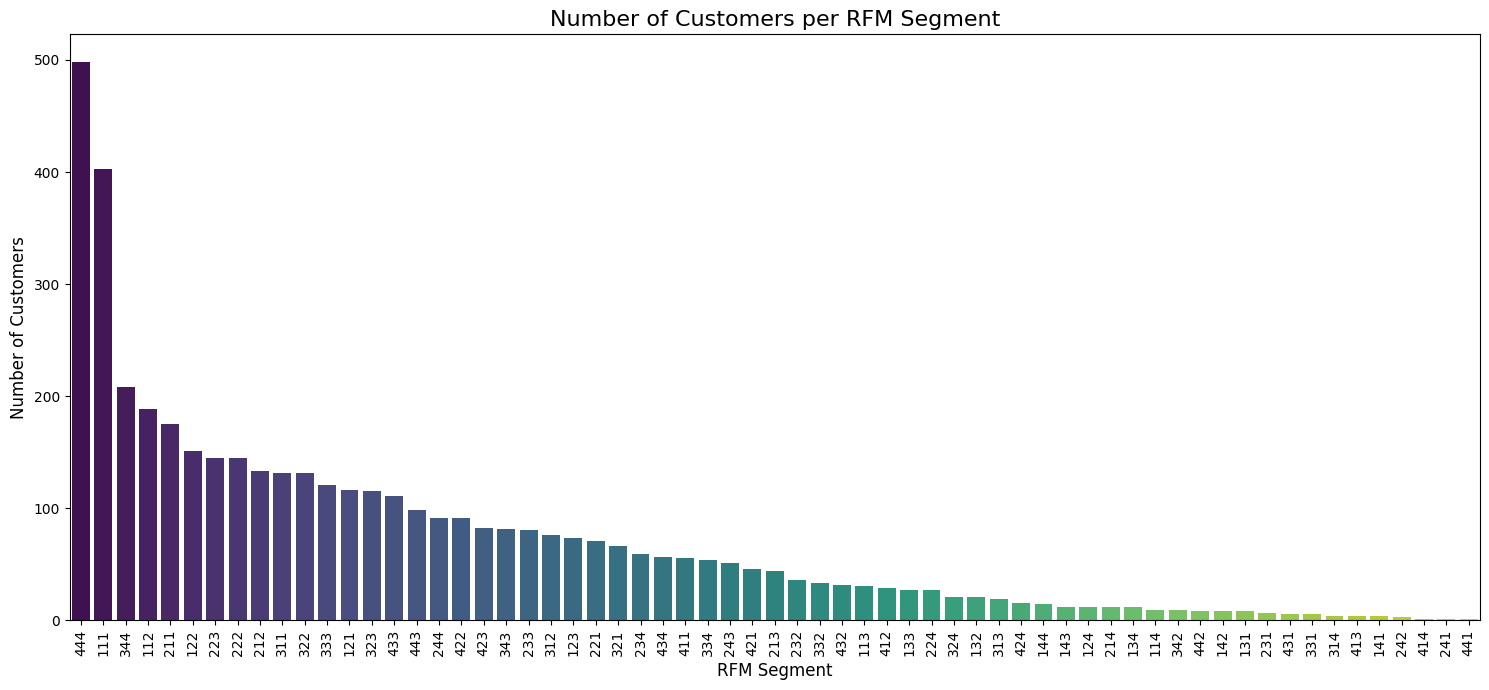

In [9]:
# Segment assignment (technical)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. count of customers in each RFM_Segment
segment_counts = rfm_df['RFM_Segment'].value_counts()

# 2. segments by count in descending order
segment_counts_sorted = segment_counts.sort_values(ascending=False)

# 3. a bar plot showing the number of customers in each RFM segment.
# Addressing FutureWarning by explicitly setting x and hue
plt.figure(figsize=(15, 7))
sns.barplot(x=segment_counts_sorted.index, y=segment_counts_sorted.values, hue=segment_counts_sorted.index, palette='viridis', legend=False)

# Labeling the axes appropriately and adding a title :).
plt.title('Number of Customers per RFM Segment', fontsize=16)
plt.xlabel('RFM Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

# 4. the bar plot.
plt.show()

In [17]:
def segment_me(row):
    if row['RFM_Score'] >= 9:
        return 'Champions'
    elif row['RFM_Score'] >= 7:
        return 'Loyal Customers'
    elif row['RFM_Score'] >= 5:
        return 'Potential Loyalists'
    else:
        return 'At Risk'

rfm_df['Segment'] = rfm_df.apply(segment_me, axis=1)

display(rfm_df.groupby('Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','count']
}))

Recency  Frequency     Monetary      
                           mean       mean         mean count
Segment                                                      
At Risk              226.334467   1.156463   195.166791   882
Champions             23.688199  10.475776  4300.563541  1610
Loyal Customers       59.976663   2.910152   883.070678   857
Potential Loyalists  106.444770   1.769306   437.174811  1023

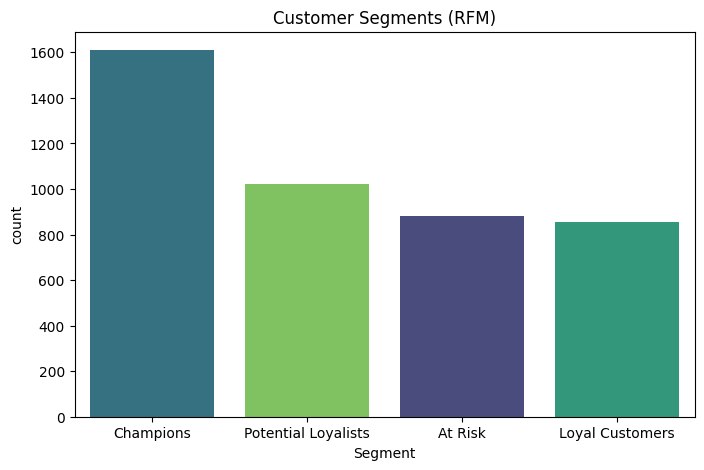

In [19]:
# Visualization (EDA)
plt.figure(figsize=(8,5))
sns. countplot(
    data=rfm_df,
    x='Segment',
    order=rfm_df['Segment'].value_counts().index,
    palette="viridis",
    hue='Segment',
    legend=False
)

plt.title("Customer Segments (RFM)")
plt.show()

# Customer Segmentation Summary and Actionable Strategy

**The RFM analysis successfully segmented our customer base into key groups, providing a clear path for targeted marketing efforts:**

1. Champions (Highest R, F, M): These are our best customers, representing the highest value.

Action: Reward them immediately to ensure loyalty. Introduce a high-tier loyalty program or early access to new products.

2. Potential Loyalists (High F, M, Moderate R): Customers who spend well and often, but are starting to slip.

Action: Re-engage with personalized recommendations based on past purchases to turn them into Champions.

3. At Risk (Low R, High F/M): These are loyal customers who haven't purchased recently. We risk losing them.

Action: Win-back campaigns, personalized emails, or special discounts to encourage an immediate return purchase.

4. Hiberating/Lost: Customers with very low scores across the board.

Action: Low priority. Use cost-effective, broad campaigns or abandon efforts to focus resources on higher-value groups.